# Code

## Standard imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import time
np.random.seed(int(time.time()))

## Specific imports

In [2]:
# import code of Zdenko Heyvaert

sys.path.insert(1, '../Zdenko/Clusters5.11') # now we can import files from this directory too
import Zdenko_timeseries_clusters as Zdenko

import sys
sys.path.insert(1, '../sglv_timeseries')

from sglv_timeseries import ibm
from sglv_timeseries import glv
from sglv_timeseries.noise_parameters import NOISE
from sglv_timeseries.models import MODEL
from sglv_timeseries.timeseries_plotting import PlotTimeseries, PlotRankAbundance, PlotTimeseriesComparison

sys.path.insert(1, '../SOI') # now we can import files from this directory too
import statevectors_Gillespie as Franziska

from matplotlib import colorbar as mcolorbar
from noise_properties_plotting import PiecewiseLogNorm, PiecewiseNormalize

from itertools import chain, count, combinations

from neutrality_analysis import JensenShannon

from matplotlib.colors import LogNorm

from heavytails import fit_heavytail, plot_heavytail, normalizations, plot_cdf_heavytail

from elife_settings import ELIFE, set_elife_settings

set_elife_settings()

load sglv_timeseries


## Random paramaters and example plot functions

In [10]:
# specify all parameters

from scipy import stats

def random_parameter_set(S, connectance=0.3, minint=-0.5, maxint=0.5,
                         minmigration=0.4, maxmigration=0.4,
                         minextinction=0.5, maxextinction=0.5, growth_rate=1.5):
    interaction = np.random.uniform(minint, maxint, [S, S])
    interaction *= np.random.choice([0, 1], interaction.shape, p=[1 - connectance, connectance])  # connectance
    np.fill_diagonal(interaction, -1.)  # self-interaction

    growth_rate = np.full([S, 1], growth_rate)
    immigration = np.random.uniform(minmigration, maxmigration, [S, 1])
    extinction = np.random.uniform(minextinction, maxextinction, [S, 1])

    params = {'interaction_matrix': interaction, 'immigration_rate': immigration,
              'extinction_rate': extinction, 'growth_rate': growth_rate}

    return params

def random_parameter_set_ibm(S, connectance=0.3, minint=-0.5, maxint=0.5,
                         minmigration=0.4, maxmigration=0.4,
                         minextinction=0.5, maxextinction=0.5, growth_rate=1.5):
    
    interaction = np.random.uniform(minint, maxint, [S, S])
    interaction *= np.random.choice([0, 1], interaction.shape, p=[1 - connectance, connectance])  # connectance
    np.fill_diagonal(interaction, -1.)  # self-interaction

    growth_rate = np.full([S, 1], growth_rate)
    immigration = np.random.uniform(minmigration, maxmigration, [S, 1])
    extinction = np.random.uniform(minextinction, maxextinction, [S, 1])

    SIS = []
    SISfactor = 200

    SISvector = np.ones(S, dtype=int)
    SISvector[SIS] *= SISfactor

    params = {'interaction_matrix' : interaction, 'immigration_rate' : immigration, 
             'extinction_rate' : extinction,
               'growth_rate' : growth_rate, 'SIS':SIS, 'SISvector':SISvector}

    return params


def random_parameter_set_logistic(S, width_growth=1):
    growth_rate = stats.lognorm.rvs(loc=0, s=width_growth, size=[S, 1])
    if np.sqrt(4 - width_growth ** 2) == 0:
        self_int = np.ones(S)
    else:
        self_int = stats.lognorm.rvs(loc=0, s=np.sqrt(4 - width_growth ** 2), size=S)

    interaction = np.zeros([S, S])
    np.fill_diagonal(interaction, -self_int)  # self-interaction

    growth_rate = np.full([S, 1], growth_rate)
    immigration = np.zeros([S, 1])
    extinction = np.zeros([S, 1])

    params = {'interaction_matrix': interaction, 'immigration_rate': immigration,
              'extinction_rate': extinction, 'growth_rate': growth_rate}

    return params

def add_SIS(interaction, SISvector):
    interaction_SIS = interaction * SISvector
    np.fill_diagonal(interaction_SIS, np.diag(interaction))
    return interaction_SIS

def parameters_to_Zdenko_parameters(interaction, growth_rate, immigration, extinction, SISvector):
    omega_Z = np.zeros((len(interaction)+1, len(interaction)+1)); 
    omega_Z[1:,1:] = interaction; omega_Z[1:,0] = growth_rate.flatten()
    mu_Z = np.hstack(([0], immigration))
    e_Z = np.hstack(([0], extinction))
    SISvector_Z = np.hstack(([1], SISvector))
    
    return omega_Z, mu_Z, e_Z, SISvector_Z

In [4]:
from variation import variation_coefficient, JS

def example_timeseries(connectance, immigration, int_strength, noise=None, 
                       max_cap=None, sites=None, S=200, 
                       noise_implementation=NOISE.LANGEVIN_LINEAR):
    
    if sites == None:
        params = random_parameter_set(S, 
           minmigration=immigration, maxmigration=immigration, connectance=connectance,
           minint=-int_strength, maxint=int_strength)
        
        if np.isinf(max_cap):
            model = MODEL.GLV
            params['initial_condition'] = np.random.uniform(0, 1, [S,1])
        else:
            model = MODEL.MAX
            params['maximum_capacity'] = max_cap
            initcond = np.random.uniform(0, 1, [S,1])
            params['initial_condition'] = initcond*max_cap/S
        if noise_implementation == NOISE.LANGEVIN_LINEAR:
            params['noise_linear'] = noise
        elif noise_implementation == NOISE.LANGEVIN_SQRT:
            params['noise_sqrt'] = noise
        elif noise_implementation == NOISE.LANGEVIN_CONSTANT:
            params['noise_constant'] = noise
        
    elif sites != None and max_cap == None:
        params = random_parameter_set_ibm(S,
           minmigration=immigration, maxmigration=immigration, 
                                          connectance=connectance,
           minint=-int_strength, maxint=int_strength)
    
        model = MODEL.IBM
        params['initial_condition'] = np.random.randint(0, int(0.66*sites/S), S)
        params['sites'] = sites
    return show_example(params, model, noise_implementation)

def example_timeseries_logistic(width_growth, noise, S=200):
    params = random_parameter_set_logistic(S, width_growth)

    #interaction_SIS = add_SIS(interaction, SISvector)
    initcond = np.random.uniform(0, 1, [S,1])
    
    params = {'interaction_matrix' : interaction, 'immigration_rate' : immigration, 
            'extinction_rate' : extinction, 'initial_condition' : initcond, 
            'noise_linear' : noise, 'growth_rate' : growth_rate}
    
    return show_example(params, MODEL.GLV)

def show_example(params, model, noise_implementation):
    # find steady state without noise
    if model in [MODEL.GLV, MODEL.MAX]:
        params_init = params.copy()
        params_init['noise_linear'] = 0
        ts = glv.Timeseries(params_init, T = 125, dt=0.005, tskip=199, model=model)
        discrete = False
    elif model == MODEL.IBM:
        ts = ibm.Timeseries(params, T = 150)
        discrete = True
        
    stab = (np.max(np.abs((ts.timeseries.iloc[-50, 1:] - ts.timeseries.iloc[-1, 1:])/ ts.timeseries.iloc[-50, 1:])) < 0.1)
    print("Deterministic solution is stable:", stab)
    #if stab == False:
    #    print(ts.timeseries.iloc[0,:])
    #    print(ts.timeseries.iloc[1,:])
    ep = ts.endpoint
    col_to_drop = ep.index[ep.endpoint < 1e-6*np.max(ep.endpoint)]
    
    PlotTimeseries(ts.timeseries.drop(columns=col_to_drop))

    if model in [MODEL.GLV, MODEL.MAX]:
        params['initial_condition'] = ts.endpoint.values.astype('float')
        ts = glv.Timeseries(params, T = 250, dt=0.005, tskip=199, model=model, noise_implementation=noise_implementation)
    elif model == MODEL.IBM:
        params['initial_condition'] = ts.endpoint.values.astype('int').flatten()
        ts = ibm.Timeseries(params, T = 250)
    PlotTimeseries(ts.timeseries.drop(columns=col_to_drop))
    params = variation_coefficient(ts.timeseries)
    print("variation:", params[0])
    params = JS(ts.timeseries, verbose=True)
    print("JS:", params[0])
    print("pval stable (higher more stable):", params[-1])
    
    ep = ts.endpoint.values.astype('float').flatten()
    ep = ep[ep > 1e-6*np.max(ep)]
    
    print("remaining species", len(ep))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    print("things", ep[0], ep[-1], len(ep), discrete)
    params = fit_heavytail(ep, func='lognorm', discrete=discrete)
    plot_heavytail(ep, params, func='lognorm', ax=ax, discrete=discrete)
    print("Width lognorm:", params[0], params[1], params[2])
    print("Stat lognorm:", params[-2])
    for f in ['expon', 'norm', 'powerlaw', 'pareto']:
        params = fit_heavytail(ep, func=f, discrete=discrete)
        plot_heavytail(ep, params, func=f, ax=ax, discrete=discrete)
        print("Stat %s:" % f, params[-2])
    params = fit_heavytail(ep, func='trunc_powerlaw', discrete=discrete)
    plot_heavytail(ep, params, func='trunc_powerlaw', ax=ax, discrete=discrete)
    print("Stat trunc powerlaw:", params[-2])
    print("R powerlaw (negative -> lognormal):", params[2])
    
    return ep

# Introduction

Gibson 2016 proved that SIS can give rise to clustering of the data.
Zdenko also obtained clusters with an IBM approach.

Whether Zdenko's results were obvious depends on how the steady states of both algorithms are connected.

# IBM

## Stability of Zdenko algorithm

Is the steady state of the Zdenko algorithm robust against changes in initial conditions? Yes

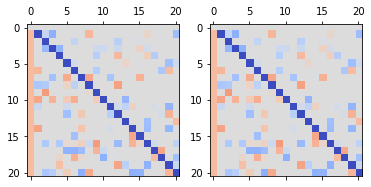

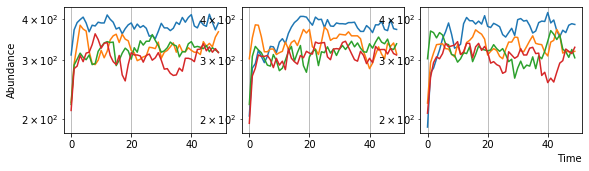

In [5]:
S = 20        # species in metacommunity
s = None      # species in local community
sites = 10000
SIS = []
SISfactor = 200

SISvector = np.ones(S, dtype=int)
SISvector[SIS] *= SISfactor

p = random_parameter_set(S)
interaction, growth_rate, immigration, extinction = p['interaction'], p['growth_rate'], p['immigration'], p['extinction']
interaction_SIS = add_SIS(interaction, SISvector)
omega_Z, mu_Z, e_Z, SISvector_Z = parameters_to_Zdenko_parameters(interaction, growth_rate, immigration, extinction, SISvector)
omega_SIS_Z, mu_Z, e_Z, SISvector_Z = parameters_to_Zdenko_parameters(interaction_SIS, growth_rate, immigration, extinction, SISvector)

# plot omega and omega with SIS
ax1 = plt.subplot(121)
vmin = - np.nanmax(abs(omega_Z)); vmax = np.nanmax(abs(omega_Z))
ax1.matshow(omega_Z, vmin=vmin, vmax=vmax, cmap='coolwarm')
#ax1.colorbar()

ax2 = plt.subplot(122)
vmin = - np.nanmax(abs(omega_SIS_Z)); vmax = np.nanmax(abs(omega_SIS_Z))
ax2.matshow(omega_SIS_Z, vmin=vmin, vmax=vmax, cmap='coolwarm')
#ax2.colorbar()
plt.show()

# generate multiple timeseries and remove the empty sites

N = 3

Z_ts = [Zdenko.timeseries(omega_Z, mu_Z, e_Z, SIS, SISvector_Z, s, sites).drop('empty', axis='columns')
        for i in range(N)]

# compare them

PlotTimeseriesComparison(Z_ts, composition=['ts'])
plt.show()

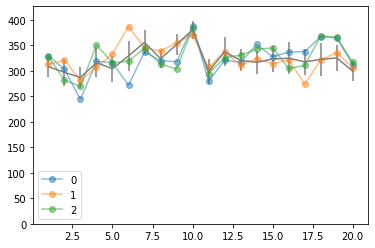

In [6]:
# plot steady states (end point of time series)

ss = [ ts[[col for col in ts.columns if col.startswith('species')]].values[-1] for ts in Z_ts]

for i, ssi in zip(count(), ss):
    plt.plot(range(1, len(ssi)+1), ssi, label=str(i), alpha=0.5, marker='o')

plt.errorbar(range(1, len(ssi)+1), Z_ts[0][[col for col in Z_ts[0].columns if col.startswith('species')]].mean(axis=0), 
            yerr=Z_ts[0][[col for col in Z_ts[0].columns if col.startswith('species')]].std(axis=0), color='grey')
#plt.yscale('log')
#print(min(np.nanmin(ss1),np.nanmin(ss2)), max(np.nanmax(ss1),np.nanmax(ss2)))
#plt.ylim(min(np.nanmin(ss1),np.nanmin(ss2)), max(np.nanmax(ss1),np.nanmax(ss2)))
plt.ylim([0, 1.1*max(chain.from_iterable(ss))]) # chain.from_iterable to flatten the ss
plt.legend()

plt.show()

## Consistent IBM 

I wrote a version of Zdenko's code that is in the line of the code I have for PLM. 
Is it the same? Yes 


In [10]:
initcond = np.random.randint(0, int(0.66*sites/S), S)

params = {'interaction_matrix' : interaction, 'immigration_rate' : immigration, 'extinction_rate' : extinction, 
          'initial_condition' : initcond, 'SISvector' : SISvector, 
          'growth_rate' : growth_rate, 'sites' : sites}

ibm_ts = [ibm.Timeseries(params, T = 50).timeseries for i in range(2)]

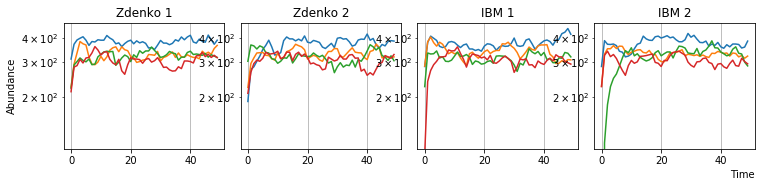

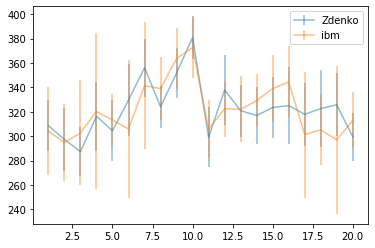

In [11]:
PlotTimeseriesComparison([Z_ts[0], Z_ts[2], ibm_ts[0], ibm_ts[1]], 
                         composition=['ts'], titles=['Zdenko 1', 'Zdenko 2', 'IBM 1', 'IBM 2'])

# plot steady states (end point of time series)

plt.figure()

if False: # plot endpoints
    ss_Z = [ ts[[col for col in ts.columns if col.startswith('species')]].values[-1] for ts in Z_ts]
    labels_Z = ['Zdenko %d' % i for i in range(1, len(ss_Z)+1)]
    ss_ibm = [ts[[col for col in ts.columns if col.startswith('species')]].values[-1] for ts in ibm_ts]
    labels_ibm = ['ibm %d' % i for i in range(1, len(ss_ibm)+1)]

    ss = ss_Z + ss_ibm
    labels = labels_Z + labels_ibm
    
    for ss, label in zip(ss, labels):
        plt.plot(range(1, len(ss)+1), ss, label=label, alpha=0.5, marker='o')
else: # plot mean and standard deviation
    for ts, label in zip([Z_ts[0],ibm_ts[0]], ['Zdenko', 'ibm']):
        plt.errorbar(range(1, len(ssi)+1), ts[[col for col in ts.columns if col.startswith('species')]].mean(axis=0), 
            yerr=ts[[col for col in ts.columns if col.startswith('species')]].std(axis=0), label=label, alpha=0.5)
    

#plt.yscale('log')
#print(min(np.nanmin(ss1),np.nanmin(ss2)), max(np.nanmax(ss1),np.nanmax(ss2)))
#plt.ylim(min(np.nanmin(ss1),np.nanmin(ss2)), max(np.nanmax(ss1),np.nanmax(ss2)))
plt.legend()

plt.show()

Not slower? No

In [10]:
%timeit Zdenko.timeseries(omega, mu, e, SIS, SISfactor, s, sites)
%timeit ibm.Timeseries(params, T = 50)

10.6 s ± 621 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.3 s ± 975 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Smaller lattice results in more noise

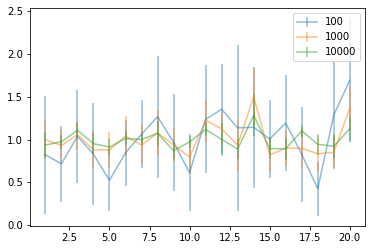

In [9]:
S = 20        # species in metacommunity
s = None      # species in local community
sites = 10000
SIS = []
SISfactor = 200

SISvector = np.ones(S, dtype=int)
SISvector[SIS] *= SISfactor

params_ibm = random_parameter_set(S)

for sites in [100, 1000, 10000]:
    initcond = np.random.randint(0, int(0.66*sites/S), S)
    
    params_ibm['initial_condition'] = initcond
    params_ibm['sites'] = sites

    ts = ibm.Timeseries(params_ibm, T = 50).timeseries
    y = ts[[col for col in ts.columns if col.startswith('species')]].mean(axis=0)
    yerr = ts[[col for col in ts.columns if col.startswith('species')]].std(axis=0)
    
    # rescale
    y, yerr = y/np.mean(y), yerr/np.mean(y)
    
    plt.errorbar(range(1, len(y)+1), y, yerr=yerr, label=sites, alpha=0.5)

plt.legend()
plt.show()

## Immigration and connectance define the width of the lognormal distribution

/Users/lana/Desktop/enterotypes_glv/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


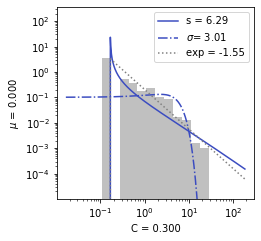

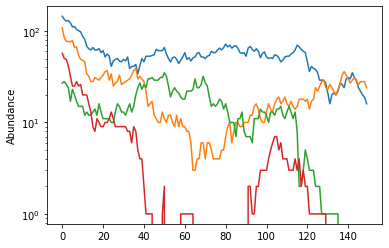

In [180]:
S = 200        # species in metacommunity
s = None      # species in local community
SIS = []
SISfactor = 200
sites = 50000

SISvector = np.ones(S, dtype=int)
SISvector[SIS] *= SISfactor

migrations = [0.0001] #[0.005] #[0.5, 0.05, 0.005]
connectances = [0.3] #[0, 0.01, 0.1]

fig_ra = plt.figure(figsize=(12,12))
gs_ra = gridspec.GridSpec(3,3)

# for migration, connectance in zip(migrations, connectances):
for i, migration in enumerate(migrations):
    for j, connectance in enumerate(connectances):
        ax = fig_ra.add_subplot(gs_ra[i,j])
        
        if i == len(migrations) - 1:
            ax.set_xlabel('C = %.3f' % connectance) 
        if j == 0:
            ax.set_ylabel(r'$\mu$ = %.3f' % migration)
            
        N = 1
        ep = np.zeros(N*S)
        
        for k in range(N):
            params_ibm = random_parameter_set(S, 
             minmigration=migration, maxmigration=migration, connectance=connectance)
            initcond = np.random.randint(0, int(0.66*sites/S), S)

            params_ibm['initial_condition'] = initcond
            params_ibm['sites'] = sites
            
            ts = ibm.Timeseries(params_ibm, T = 150)
            
            PlotTimeseries(ts.timeseries)
            
            ep[k*200:(k+1)*200] = ts.endpoint.values.astype('float').flatten()
        
        for func, ls in zip(['lognorm', 'norm', 'powerlaw'], ['-', '-.', ':']):
            params = fit_heavytail(ep, func=func)
            plot_heavytail(ep, params, func=func, ax=ax, linestyle=ls, 
                       xscale='log', yscale='log')
#ax_hist.legend()
plt.show()

## Steady state gLV with maximum capacity

Steady state of gLV is not the same as steady state of IBM
The steady state of IBM is closer to equal distribution of species.

What are the differences in the implementation? The growth rate is dependent on the emptyness of the lattice for IBM.

In an IBM implementation the differences between the species are less big, the steady states are closer to an equal partitioning of the species.

\begin{align}
d x_i(t) &= \left(\lambda_i + g_i x_i(t) + \sum_j \omega_{ij} x_i(t) x_j(t) - \frac{\sum_k x_k(t)}{\Nmax} \left( g_i^+ x_i(t) + \sum_j \omega_{ij}^+ x_i x_j\right)\right) dt \\
&= \left( \lambda_i + g_i x_i(t) + \sum_j \left( \omega_{ij} - \frac{g_i^+}{\Nmax} \right) x_i(t) x_j(t) - \sum_j \sum_k \frac{\omega_{ij}^+}{\Nmax}  x_i(t) x_j(t) x_k(t) \right) dt
\end{align}

Adding a maximum capacity, makes the steady state closer to the IBM results.

<font color='red'> TODO Derive this result analytically </font>

In [21]:
def test():
    N = 10

    A = np.random.normal(0, 0.1, [N,N])
    np.fill_diagonal(A, -1)
    g = np.random.uniform(0, 5, [N,1])

    offdiag = np.full([N,N], -0.1); np.fill_diagonal(offdiag, 0)
    omega = A + offdiag

    v = -np.linalg.inv(A).dot(g)
    v2 = -np.linalg.inv(omega).dot(g)

    print(v - v2)
    plt.hist(v, alpha=0.2, label='A')
    plt.hist(v2, alpha=0.2, label='max cap')
    plt.legend()
    plt.show()

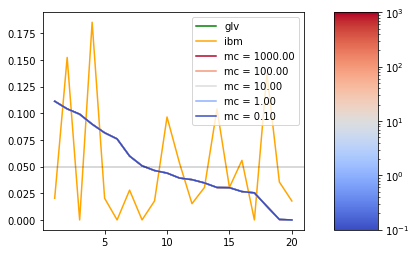

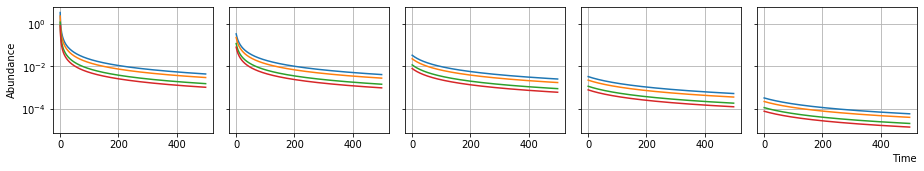

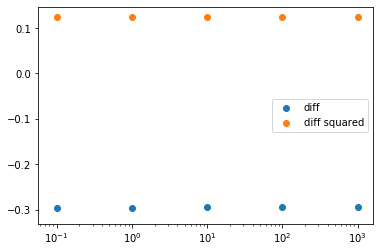

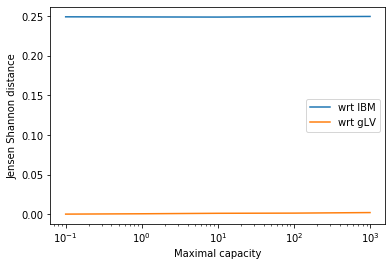

In [33]:
# maximal capacity closer to all same value?

# specify all parameters

S = 20        # species in metacommunity
s = None      # species in local community
sites = 10000
SIS = []
SISfactor = 200

SISvector = np.ones(S, dtype=int)
SISvector[SIS] *= SISfactor

interaction, growth_rate, immigration, extinction
params_ibm = random_parameter_set(S, minmigration=0, maxmigration=0)
params_ibm['interaction_matrix'] = add_SIS(params['interaction_matrix'], SISvector)
params_ibm['initial_condition'] = np.random.randint(0, int(0.66*sites/S), S), 
params_ibm['sites'] = sites

ibm_ep = ibm.Timeseries(params_ibm, T = 50).endpoint.to_numpy().flatten()

params_glv = {'interaction_matrix' : interaction_SIS, 'growth_rate' : growth_rate, 'immigration_rate' : immigration,
          'extinction_rate' : extinction, 'noise_linear' : 0, 'initial_condition' : np.random.uniform(0,1,[S,1])}

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[6,1])
ax = fig.add_subplot(gs[0])

ts = glv.Timeseries(params_glv, dt=1e-2, tskip=9, T=100, seed=int(time.time()))
glv_ts = ts.timeseries 
glv_ep = ts.endpoint.to_numpy().flatten()
order = np.argsort(glv_ep)[::-1]
ax.plot(range(1, S+1), glv_ep[order] / np.sum(glv_ep), label='glv', color='green')
ax.plot(range(1, S+1), ibm_ep[order] / np.sum(ibm_ep), label='ibm', color='orange')

reducers = [1000, 100, 10, 1, 0.1]
glv_mc_ts = [None] * len(reducers)
glv_mc_ep = [None] * len(reducers)

cmap = plt.cm.get_cmap('seismic')
norm = LogNorm(min(reducers), max(reducers))

for i, reducer in enumerate(reducers):
    params_glv['maximum_capacity'] = reducer
    params_glv['initial_condition'] = 0.005 * reducer * glv_ep.reshape([S,1]) #* np.random.uniform(0.5,1,[S,1])
    
    ts = glv.Timeseries(params_glv, dt=5e-2, tskip=19, T=500, seed=int(time.time()), 
                                  model=MODEL.MAX)
    glv_mc_ts[i] = ts.timeseries
    ep = ts.endpoint.to_numpy().flatten()
    glv_mc_ep[i] = ep
    
    ax.plot(range(1, S+1), ep[order] / np.sum(ep), label='mc = %.2f' % reducer, color=cmap(norm(reducer)))

ax_cbar = fig.add_subplot(gs[1])
mcolorbar.ColorbarBase(ax_cbar, cmap=plt.cm.coolwarm, orientation='vertical', norm=norm)

ax.axhline(y=1/len(ep), c='k', alpha=0.2)
ax.legend()

average_ep = np.mean(np.array(glv_mc_ep))

PlotTimeseriesComparison(glv_mc_ts, composition=['ts'])
plt.show()
              
differences = [np.mean(ss - glv_ep) for ss in glv_mc_ep]
square_differences = [np.mean((ss - glv_ep)**2) for ss in glv_mc_ep]

plt.scatter(reducers, differences, label="diff")
plt.scatter(reducers, square_differences, label="diff squared")
plt.legend()
plt.xscale('log')
plt.show()
              
JS_ibm = [JensenShannon(ts.iloc[-1]['species_1':]/np.sum(ts.iloc[-1]['species_1':]), 
                        ibm_ts.iloc[-1]['species_1':]/np.sum(ibm_ts.iloc[-1]['species_1':])) for ts in glv_mc_ts]
JS_glv = [JensenShannon(ts.iloc[-1]['species_1':]/np.sum(ts.iloc[-1]['species_1':]), 
                        glv_ts.iloc[-1]['species_1':]/np.sum(glv_ts.iloc[-1]['species_1':])) for ts in glv_mc_ts]

plt.plot(reducers, JS_ibm, label='wrt IBM')
plt.plot(reducers, JS_glv, label='wrt gLV')
plt.xscale('log')
plt.xlabel('Maximal capacity')
plt.ylabel('Jensen Shannon distance')
plt.legend()
plt.show()

In [54]:
new = True

def random_ts():
    S = 20                              # number of species in the metacommunity
    s = None                           # number of species in each local community
    sites = 10000
    connectance = 0.3

    SIS = [1]
    SISfactor_ = 1  # 200
    maxint = 0.5
    minmigration = 0.4
    maxmigration = 0.4
    minextinction = 0.3
    maxextinction = 0.3

    SISfactor = np.ones(S+1, dtype=int)
    SISfactor[SIS] *= SISfactor_

    omega = np.random.uniform(-maxint, maxint, [S+1, S+1])
    omega *= np.random.choice([0, 1], omega.shape,
                              p=[1-connectance, connectance])  # connectance
    omega[:, 0] = 0.3  # growth rates

    np.fill_diagonal(omega, -1.)  # self-interaction
    omega[0, :] = 0  # no growth of empty sites

    omega_SIS = omega * SISfactor
    omega_SIS[SIS, SIS] = omega[SIS, SIS] * np.sqrt(SISfactor[SIS])

    # immigration rates
    mu = np.random.uniform(minmigration, maxmigration, [S+1])
    mu[0] = 0

    # extinction rates
    e = np.random.uniform(minextinction, maxextinction, [S+1])
    e[0] = 0

    initcond = np.full([S+1], int(0.66*sites/S))
    initcond[0] = sites - sum(initcond[1:])

    ibm_ts = [ibm.run_timeseries(
        omega, mu, e, initcond, SISfactor).iloc[-1]['species_1':].astype(float).to_numpy().flatten() 
              for i in range(3)]

    params = {}
    params['interaction_matrix'] = omega_SIS[1:, 1:]
    params['growth_rate'] = omega[1:, 0].reshape([S, 1])
    params['immigration_rate'] = mu[1:].reshape([S, 1])
    params['noise_linear'] = 0

    params['initial_condition'] = np.random.uniform(0, 1, [S, 1])

    glv_ts = glv.Timeseries(params, dt=1e-2, tskip=9, T=100,
                            seed=int(time.time())).endpoint.astype(float).to_numpy().flatten()

    mc_reducers = [10, 1, 0.5, 0.1, 0.05, 0.01]
    noises = [0, 0.01, 0.05]

    glv_mc_ts = [None] * len(noises) * len(mc_reducers)

    for j, noise in enumerate(noises):
        for i, reducer in enumerate(mc_reducers):
            params['maximum_capacity'] = reducer * np.sum(glv_ts)
            params['initial_condition'] = reducer * \
                np.random.uniform(0, 1, [S, 1])
            params['noise_linear'] = noise
            glv_mc_ts[j*len(mc_reducers) + i] = glv.Timeseries(params, dt=1e-2,
              tskip=19, T=100, seed=int(time.time()), model=MODEL.MAX).endpoint.astype(float).to_numpy().flatten()

    JS_ibm = [np.mean([JensenShannon(ibm_i, ibm_j) for ibm_i, ibm_j in
                       combinations(ibm_ts, r=2)])] + \
        [np.mean([JensenShannon(glv_ts, ibm_i) for ibm_i in ibm_ts])] + \
        [np.mean([JensenShannon(glv_mc_ts_i, ibm_i) for ibm_i in ibm_ts])
         for glv_mc_ts_i in glv_mc_ts]

    JS_glv = [np.mean([JensenShannon(ibm_i, glv_ts) for ibm_i in ibm_ts])] + \
        [JensenShannon(glv_ts, glv_ts)] + \
        [JensenShannon(glv_mc_ts_i, glv_ts) for glv_mc_ts_i in glv_mc_ts]

    return JS_ibm, JS_glv


if new:
    Nibm = 3
    mc_reducers = [10, 1, 0.5, 0.1, 0.05, 0.01]

    tuples_top = ['ibm'] + ['glv'] + ['glv_mc'] * len(mc_reducers) + \
        ['glv_mc_noise001'] * len(mc_reducers) + \
        ['glv_mc_noise005'] * len(mc_reducers)
    tuples_bottom = [1] + [1] + mc_reducers * 3

    tuples = list(zip(*[tuples_top, tuples_bottom]))

    multi_col = pd.MultiIndex.from_tuples(tuples, names=['first', 'second'])

    index = range(10)

    df_ibm = pd.DataFrame(index=index, columns=multi_col)
    df_glv = pd.DataFrame(index=index, columns=multi_col)

    for i in index:
        JS_ibm, JS_glv = random_ts()
        df_ibm.loc[i] = JS_ibm
        df_glv.loc[i] = JS_glv
        
    df_ibm.to_csv('comparison_ibm_glv/JS_to_ibm2.csv')
    df_glv.to_csv('comparison_ibm_glv/JS_to_glv2.csv')

For large maximal capacity, the steady state are close to the gLV solutions and further from the IBM solution (expected). For decreasing maximal capacity (stronger saturation constraints) the solution becomes closer to the IBM solution and further from the gLV (this is what we wanted).
The dotted line is the distance between several replicates of IBM simulations, this is the distance we want to obtain with the blue curve. The dash-dotted line is the distance gLV is from IBM. We don't want to perform worse than gLV, so we want to stay under this line.

<font color="red"> TODO Check typical JS distances between experimental data of same / different clusters. <br>
    Do this analysis for larger number of species </font>

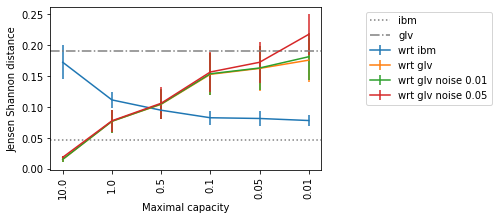

In [61]:
df_ibm_mean = df_ibm.mean(axis='rows')
df_glv_mean = df_glv.mean(axis='rows')
df_ibm_std = df_ibm.std(axis='rows')
df_glv_std = df_glv.std(axis='rows')

fig = plt.figure(figsize=(8,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax = fig.add_subplot(gs[0])
ax_l = fig.add_subplot(gs[1], frameon=False)
ax_l.axis('off')

ax.axhline(df_ibm_mean['ibm'].to_numpy()[0], label='ibm', color='grey', linestyle=':')
ax.axhline(df_ibm_mean['glv'].to_numpy()[0], label='glv', color='grey', linestyle='-.')

x = range(len(df_ibm_mean['glv_mc'].index))

ax.errorbar(x, df_ibm_mean['glv_mc'].to_numpy(), df_ibm_std['glv_mc'].to_numpy(), 
            label='wrt ibm')
ax.errorbar(x, df_glv_mean['glv_mc'].to_numpy(), df_glv_std['glv_mc'].to_numpy(),
            label='wrt glv')
ax.errorbar(x, df_glv_mean['glv_mc_noise001'].to_numpy(), df_glv_std['glv_mc_noise001'].to_numpy(),
           label='wrt glv noise 0.01')
ax.errorbar(x, df_glv_mean['glv_mc_noise005'].to_numpy(), df_glv_std['glv_mc_noise005'].to_numpy(),
            label='wrt glv noise 0.05')

ax.set_xticks(x)
ax.set_xticklabels(df_ibm_mean['glv_mc'].index, rotation=90)
ax.set_ylabel('Jensen Shannon distance')
ax.set_xlabel('Maximal capacity')

h, l = ax.get_legend_handles_labels()
ax_l.legend(h, l)
plt.show()

# Are IBM and gLV the same in the absence of immigration? No

In [17]:
# specify all parameters

S = 20                              # number of species in the metacommunity
s = None                           # number of species in each local community
sites = 10000
connectance = 0.3               

SIS = [1]
SISfactor_ = 200
maxint = 0.5
minmigration = 0.5; maxmigration = 0.5
minextinction = 0.3; maxextinction = 0.3

SISfactor = np.ones(S+1, dtype=int)
SISfactor[SIS] *= SISfactor_

omega = np.random.uniform(-maxint,maxint, [S+1, S+1])
omega *= np.random.choice([0, 1], omega.shape, p=[1-connectance, connectance]) # connectance
omega[:,0] = 0.3 # growth rates

np.fill_diagonal(omega, -1.) # self-interaction
omega[0,:] = 0 # no growth of empty sites

omega_SIS = omega * SISfactor
omega_SIS[SIS, SIS] = omega[SIS, SIS] * np.sqrt(SISfactor[SIS]) 

# immigration rates
mu = np.random.uniform(minmigration,maxmigration, [S+1]); mu[0] = 0

# extinction rates
e = np.random.uniform(minextinction,maxextinction, [S+1]); e[0] = 0

initcond = np.full([S+1], int(0.66*sites/S))
initcond[0] = sites - sum(initcond[1:])

# produce 2 time series with different initial conditions but same parameters

params = {}
params['interaction_matrix'] = omega_SIS[1:,1:]
params['growth_rate'] = omega[1:,0].reshape([S, 1])
params['immigration_rate'] = mu[1:].reshape([S, 1])
params['noise_linear'] = 0

params['initial_condition'] = np.random.uniform(0,1,[S,1])

/Users/wkits/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full([21], 330) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


/Users/wkits/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


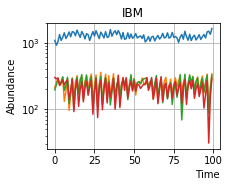

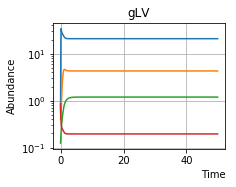

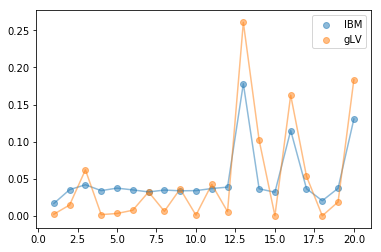

In [18]:
ibm_noim_ts = ibm.run_timeseries(omega, mu, e, initcond, SISfactor, T=100)

params['immigration_rate'] = mu[1:].reshape([S, 1])
glv_noim_ts = glv.Timeseries(params, dt=1e-2, tskip=9, T=50, seed=int(time.time())).timeseries

PlotTimeseriesComparison([ibm_noim_ts], composition=['ts'], titles=['IBM'])
PlotTimeseriesComparison([glv_noim_ts], composition=['ts'], titles=['gLV'])

# plot steady states (end point of time series)

plt.figure()

for ts, label in zip([ibm_noim_ts, glv_noim_ts], ['IBM', 'gLV']):
    # get steady state (endpoint time series)
    ss = ts[[col for col in ts.columns if col.startswith('species')]].values[-1]
    
    # normalize
    ss_norm = ss/np.sum(ss)
    
    # plot
    plt.plot(range(1, len(ss)+1), ss_norm, alpha=0.5)
    plt.scatter(range(1, len(ss)+1), ss_norm, label=label, alpha=0.5)
plt.legend()

plt.show()

# Gillespie IBM 

What about the algorithm based on the one of Franziska?

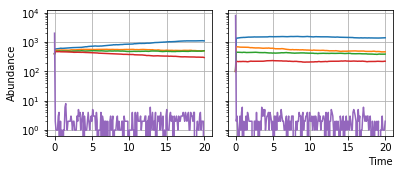

In [94]:
# produce 2 time series with different initial conditions but same parameters

S = 20
sites = 10000

params = {}
params['interaction_matrix'] = omega_SIS[1:S+1,1:S+1] / sites
params['growth_rate'] = omega[1:S+1,0].reshape([S, 1]) / sites
params['immigration_rate'] = mu[1:S+1].reshape([S, 1])
params['noise_linear'] = 0

propfunc = Franziska.propensities_Franziska(params)

initcond = np.full([S+1], int(0.8*sites/S))
initcond[0] = sites - sum(initcond[1:])
f_ts1 = Franziska.TimeseriesGillespie(propfunc, dt=1e-1, T=20, initcond=initcond, empty=0).timeseries

initcond = np.full([S+1], int(0.2*sites/S))
initcond[0] = sites - sum(initcond[1:])
f_ts2 = Franziska.TimeseriesGillespie(propfunc, dt=1e-1, T=20, initcond=initcond, empty=0).timeseries

PlotTimeseriesComparison([f_ts1, f_ts2], composition=['ts'])
plt.show()

In [ ]:
plt.figure()

for ts, label in zip([Z_ts1, Z_ts2, ibm_ts, glv_ts1, glv_ts2], 
                     ['Zdenko 1', 'Zdenko 2', 'IBM', 'gLV 1', 'gLV 2']):
    # get steady state (endpoint time series)
    ss = ts[[col for col in ts.columns if col.startswith('species')]].values[-1]
    
    # normalize
    ss_norm = ss/np.sum(ss)
    
    # plot
    plt.plot(range(1, len(ss)+1), ss_norm, alpha=0.5)
    plt.scatter(range(1, len(ss)+1), ss_norm, label=label, alpha=0.5)
plt.legend()

plt.show()

# Do we need immigration for stability?

In [7]:
# specify all parameters

S = 20                              # number of species in the metacommunity
s = None                           # number of species in each local community
sites = 10000
connectance = 0.3               

SIS = [1]
SISfactor_ = 1 #200
maxint = 0.5
minmigration = 0.; maxmigration = 0.
minextinction = 0.3; maxextinction = 0.3

SISfactor = np.ones(S+1, dtype=int)
SISfactor[SIS] *= SISfactor_

omega = np.random.uniform(-maxint,maxint, [S+1, S+1])
omega *= np.random.choice([0, 1], omega.shape, p=[1-connectance, connectance]) # connectance
omega[:,0] = 0.3 # growth rates

np.fill_diagonal(omega, -1.) # self-interaction
omega[0,:] = 0 # no growth of empty sites

omega_SIS = omega * SISfactor
omega_SIS[SIS, SIS] = omega[SIS, SIS] * np.sqrt(SISfactor[SIS]) 

# immigration rates
mu = np.random.uniform(minmigration,maxmigration, [S+1]); mu[0] = 0

# extinction rates
e = np.random.uniform(minextinction,maxextinction, [S+1]); e[0] = 0

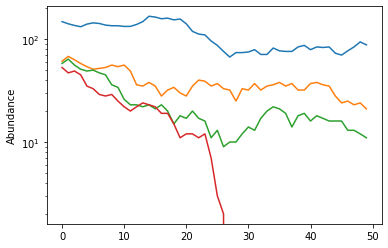

In [8]:
ts = Zdenko.timeseries(omega, mu, e, SIS, SISfactor, s, sites).drop('empty', axis='columns')
PlotTimeseries(ts)

# Rank abundance

No handles with labels found to put in legend.


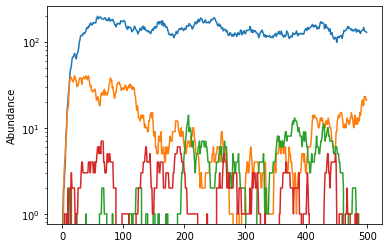

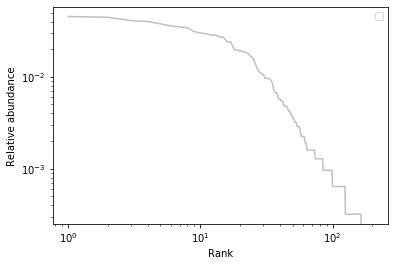

In [40]:
# specify all parameters

S = 200                              # number of species in the metacommunity
s = None                           # number of species in each local community
sites = 4000
connectance = 0.01               

SIS = [1]
SISfactor_ = 1 #200
maxint = 0.5
minmigration = 0.025; maxmigration = 0.025
minextinction = 0.1; maxextinction = 0.1

SISfactor = np.ones(S+1, dtype=int)
SISfactor[SIS] *= SISfactor_

omega = np.random.uniform(-maxint,maxint, [S, S])
omega *= np.random.choice([0, 1], omega.shape, p=[1-connectance, connectance]) # connectance
np.fill_diagonal(omega, -1.) # self-interaction

growth_rates = np.random.uniform(0, 0.6, S)

# immigration rates
mu = np.random.uniform(minmigration,maxmigration, [S+1]); mu[0] = 0

# extinction rates
e = np.random.uniform(minextinction,maxextinction, [S+1]); e[0] = 0

# initial condition
initcond = np.zeros(S, dtype=int); initcond[0:2] = 1;

params = {}
params['interaction_matrix'] = omega
params['SISvector'] = SISfactor
params['immigration_rate'] = mu
params['extinction_rate'] = e
params['initial_condition'] = initcond
params['sites'] = sites
params['growth_rate'] = growth_rates

ts = ibm.Timeseries(params, T=500)

PlotTimeseries(ts.timeseries)

PlotRankAbundance(ts.endpoint) 

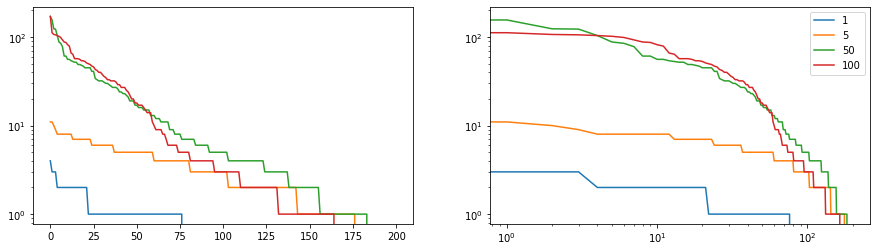

In [45]:
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for ax in [ax1, ax2]:
    ax.plot(np.sort(ts.timeseries.iloc[1])[::-1], label='1')
    ax.plot(np.sort(ts.timeseries.iloc[5])[::-1], label='5')
    ax.plot(np.sort(ts.timeseries.iloc[49])[::-1], label='50')
    ax.plot(np.sort(ts.timeseries.iloc[99])[::-1], label='100')

    ax.set_yscale('log')
ax2.set_xscale('log')
plt.legend()